# Customer Analytics in FMGC Industry (Part 2)

In [9]:
import warnings
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

sns.set()
plt.rc("font", size=14)
warnings.filterwarnings("ignore")
pd.set_option('display.max_column',None)
sns.set(style="whitegrid", color_codes=True)

### 1. Data Preparation 

In [2]:
purchase_df = pd.read_csv("/Users/mac/Desktop/DataScience/Pojects_ds/Customer Analytics FMCG/purchase data.csv", index_col=0)
price_elasticities = pd.read_csv('/Users/mac/Desktop/DataScience/Pojects_ds/Customer Analytics FMCG/price_elasticities.csv', index_col = 0)

#Import Scaler,PCA,KMeans
scaler = pickle.load(open('/Users/mac/Desktop/DataScience/Pojects_ds/Customer Analytics FMCG/scaler.pickle','rb'))
pca = pickle.load(open('/Users/mac/Desktop/DataScience/Pojects_ds/Customer Analytics FMCG/pca.pickle','rb'))
kmeans_pca = pickle.load(open('/Users/mac/Desktop/DataScience/Pojects_ds/Customer Analytics FMCG/kmeans_pca.pickle','rb'))

#making both of these cols as normal first by doing log normal transformation
purchase_df['age_log'] = np.log(purchase_df['Age'])
purchase_df['income_log'] = np.log(purchase_df['Income'])

#standardization
features = purchase_df[['Sex','Marital status','Education','Occupation','Settlement size','age_log','income_log']]
purchase_segm_std = scaler.transform(features)

#apply pca
purchase_segm_pca = pca.transform(purchase_segm_std)

#segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(purchase_segm_pca)

# Create a copy of the data frame
purchase_predictors = purchase_df.copy()

# Add segment labels to purchase_predictors DataFrame
purchase_predictors['Segment'] = purchase_segm_kmeans_pca

# Create segment dummies DataFrame
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix='Segment', prefix_sep='_')

# Add ID column to segment dummies DataFrame
segment_dummies['ID'] = purchase_predictors.index

# Set ID as index of segment dummies DataFrame
segment_dummies = segment_dummies.set_index('ID')

# Merge purchase_predictors and segment dummies DataFrames on ID column
purchase_predictors = pd.concat([purchase_predictors, segment_dummies], axis=1)

In [3]:
df_pa = purchase_predictors.copy()
df_pa.head()

,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,age_log,income_log,Segment,Segment_0,Segment_1,Segment_2,Segment_3
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,2.66,0,1,0,0,0,0,0,47,1,110866,1,0,3.850148,11.616078,0,1,0,0,0
200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,3.850148,11.616078,0,1,0,0,0
200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,3.850148,11.616078,0,1,0,0,0
200000001,16,0,0,0,0,0,1.52,1.89,1.98,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,3.850148,11.616078,0,1,0,0,0
200000001,18,0,0,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,3.850148,11.616078,0,1,0,0,0


### 2. Predictive Analysis 
In this section of predictive analysis, I apply a supervised machine learning model to estimate price elasticities and predict their effect on purchase quantity. As before, customers had visited the store, and chose a brand, and not they are deciding what quantity or how many units of the product category of interest will the customer buy.

### Modelling Purchase Quantity<br>
<li>1. Price Elasticity of Purchase Quantity</li>
<li>2. Model Estimation: Multi-Linear Regression</li>
<li>3. Price Elasticity Estimation</li> 

> First I built a statistical model to estimate purchase quantity for each customer on each shopping trip. Then the price elasticity of purchase quantity under different conditions is calculated. To do so, I employ linear regression, since we have a numeric, continuous variables to be predicted and the linear regression algorithm is intuitive to interpret.

#### 1. Price Elasticity of Purchase Quantity
Not considering the people who did not buy.

In [4]:
purchase_quantity = df_pa.query('Incidence == 1')
purchase_quantity.head()

,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,age_log,income_log,Segment,Segment_0,Segment_1,Segment_2,Segment_3
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
200000001,28,1,2,2,0,0,1.50,1.90,1.99,2.09,2.67,0,0,0,0,0,0,0,47,1,110866,1,0,3.850148,11.616078,0,1,0,0,0
200000001,58,1,5,1,0,0,1.39,1.90,1.91,2.12,2.62,1,0,0,0,1,0,0,47,1,110866,1,0,3.850148,11.616078,0,1,0,0,0
200000001,110,1,1,2,0,0,1.47,1.90,1.99,1.97,2.67,0,0,0,1,0,0,0,47,1,110866,1,0,3.850148,11.616078,0,1,0,0,0
200000001,142,1,4,1,0,0,1.21,1.35,1.99,2.16,2.68,1,1,0,0,0,0,0,47,1,110866,1,0,3.850148,11.616078,0,1,0,0,0
200000001,183,1,2,3,0,0,1.46,1.88,1.97,1.89,2.37,1,0,0,1,1,0,0,47,1,110866,1,0,3.850148,11.616078,0,1,0,0,0


In [5]:
# Create brand dummies, for each of the 5 brands.
purchase_quantity = pd.get_dummies(purchase_quantity, columns = ['Brand'], prefix = 'Brand', prefix_sep = '_')

# Turn off scientific notation in pandas 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
purchase_quantity.describe()

,Day,Incidence,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,age_log,income_log,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
count,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00
mean,359.61,1.00,2.77,1.54,0.41,1.38,1.76,2.01,2.16,2.65,0.37,0.35,0.04,0.13,0.05,0.36,0.39,40.35,1.15,126706.45,0.85,0.80,3.65,11.70,1.17,0.35,0.27,0.24,0.14,0.09,0.31,0.06,0.20,0.34
std,205.35,0.00,1.80,2.06,0.49,0.09,0.18,0.05,0.09,0.10,0.48,0.48,0.20,0.33,0.21,0.48,0.49,12.35,0.63,39935.11,0.63,0.81,0.30,0.30,1.06,0.48,0.44,0.43,0.35,0.29,0.46,0.23,0.40,0.47
min,1.00,1.00,1.00,0.00,0.00,1.10,1.26,1.87,1.76,2.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.00,0.00,38247.00,0.00,0.00,2.89,10.55,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,175.00,1.00,2.00,0.00,0.00,1.34,1.57,1.97,2.12,2.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00,31.00,1.00,102723.00,0.00,0.00,3.43,11.54,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,355.00,1.00,2.00,0.00,0.00,1.39,1.88,2.01,2.18,2.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,37.00,1.00,122895.00,1.00,1.00,3.61,11.72,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,532.00,1.00,3.00,4.00,1.00,1.47,1.89,2.06,2.24,2.70,1.00,1.00,0.00,0.00,0.00,1.00,1.00,49.00,2.00,147967.00,1.00,1.00,3.89,11.90,2.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
max,727.00,1.00,15.00,5.00,1.00,1.59,1.90,2.14,2.26,2.80,1.00,1.00,1.00,1.00,1.00,1.00,1.00,75.00,3.00,309364.00,2.00,2.00,4.32,12.64,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


> The descriptive analysis shows that on an average the customer buys at least 2-3 chocolates. And the range is between 1-15.

In [6]:
purchase_quantity['Price_Incidence'] = (purchase_quantity['Brand_1'] * purchase_quantity['Price_1'] +
                                        purchase_quantity['Brand_2'] * purchase_quantity['Price_2'] +
                                        purchase_quantity['Brand_3'] * purchase_quantity['Price_3'] +
                                        purchase_quantity['Brand_4'] * purchase_quantity['Price_4'] +
                                        purchase_quantity['Brand_5'] * purchase_quantity['Price_5'] )

# Indicate incidences whether each brand is purchased with/ without promotion
purchase_quantity['Promotion_Incidence'] = (purchase_quantity['Brand_1'] * purchase_quantity['Promotion_1'] +
                                            purchase_quantity['Brand_2'] * purchase_quantity['Promotion_2'] +
                                            purchase_quantity['Brand_3'] * purchase_quantity['Promotion_3'] +
                                            purchase_quantity['Brand_4'] * purchase_quantity['Promotion_4'] +
                                            purchase_quantity['Brand_5'] * purchase_quantity['Promotion_5'] )

#### 2. Model Estimation: Multi-Linear Regression

In [7]:
inputs = purchase_quantity[['Sex', 'Price_Incidence', 'Promotion_Incidence' ]]
output = purchase_quantity['Quantity']

In [10]:
model_quantity = LinearRegression()
model_quantity.fit(inputs,output)

LinearRegression()

In [11]:
#checking the coef
model_quantity.coef_

array([ 0.16177376, -0.77559549, -0.0921756 ])

- In general, coefficients show the change in the dependent variable that is going to occur with a unit change in the respective independent variable. 
- The first coefficient refers to Sex. Since the coefficient is positive, we can interpret that females (Sex =1) are likely to purchase ca.  0.1618 units more chocolates than males (Sex = 0).  
- The second coefficient is related to the change of price of the purchased product. For each dollar increase in price, ca. 0.7756 units less chocolates will be bought. This is intuitive, as price increases, purchase quantity naturally decreases. 
- According to the last coefficient, when there is a promotion ca. 0.0922 units less will be bought. In other words, people would buy a bit less when there is a promotion. This is quite counter-intuitive. 
- In my opinion, this might be occurred due to over-simplified regression model. After backwards variables selection, only 4 predicters are left. There might be some other important features which affect on purchase quantity, and they are missing in the given dataset. 
- Another plausible explanation could be we are considering the "average customer", not any particular segment. Or it is also possible that a promotion is prompting a customer to try out a new brand. In that case, we would not expect them to buy many chocolate bars but a single one.

#### 3. Price Elasticity Estimation vs. Promotion

In [12]:
price_range = np.arange(0.5, 3.5, 0.01)

# Examine the price elasticity of purchase quantity with active promotional activities for each price point.
price_elasticity_quantity = pd.DataFrame({'Sex' : 0.5,  
                                          'Price_Incidence':price_range, 
                                          'Promotion_Incidence' :1,              # With Promotion                           
                                          'No_Promotion_Incidence' : 0},         # With Promotion     
                                        index = np.arange(price_range.size))
# Take the coefficient for price.
beta_quantity = model_quantity.coef_[1]

# Find the new predicted quantities.
predict_quantity_prom = model_quantity.predict(price_elasticity_quantity.iloc[:, :3])
predict_quantity_prom_x = model_quantity.predict(price_elasticity_quantity.iloc[:, np.r_[0:2,3]])

### Price Elasticity of Demand 

I calculate probability of purchase quantity with the help of a linear regression model. Then, using the obtained probabilities, we can determine the price elasticities as: The beta coefficient for price times Price divided by the purchase quantity.

$$ E = -\beta(Own Product Price)/Quantity(purchase) $$ 

[Price Elasticity - Reference](https://365datascience.com/price-elasticity/)

In [13]:
# Calculate the price elasticity with the new formula. It is the beta coefficient for price multiplied by price
# and divided by the purchase quantity.
price_elasticity_quantity_promotion_yes = beta_quantity * price_range / predict_quantity_prom
price_elasticity_quantity_promotion_no = beta_quantity * price_range / predict_quantity_prom_x

price_elasticities.loc['PE_Quantity_Prom_Yes'] = price_elasticity_quantity_promotion_yes
price_elasticities.loc['PE_Quantity_Prom_No'] = price_elasticity_quantity_promotion_no
pd.options.display.max_columns = None
# Master dataframe of price elasticity
price_elasticities.to_csv('price_elasticities_Master.csv')
price_elasticities 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
Price Point,0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.10,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.30,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.40,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.50,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.60,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.70,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.80,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.90,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.00,2.01,2.02,2.03,2.04,2.05,2.06,2.07,2.08,2.09,2.10,2.11,2.12,2.13,2.14,2.15,2.16,2.17,2.18,2.19,2.20,2.21,2.22,2.23,2.24,2.25,2.26,2.27,2.28,2.29,2.30,2.31,2.32,2.33,2.34,2.35,2.36,2.37,2.38,2.39,2.40,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48,2.49,2.50,2.51,2.52,2.53,2.54,2.55,2.56,2.57,2.58,2.59,2.60,2.61,2.62,2.63,2.64,2.65,2.66,2.67,2.68,2.69,2.70,2.71,2.72,2.73,2.74,2.75,2.76,2.77,2.78,2.79,2.80,2.81,2.82,2.83,2.84,2.85,2.86,2.87,2.88,2.89,2.90,2.91,2.92,2.93,2.94,2.95,2.96,2.97,2.98,2.99,3.00,3.01,3.02,3.03,3.04,3.05,3.06,3.07,3.08,3.09,3.10,3.11,3.12,3.13,3.14,3.15,3.16,3.17,3.18,3.19,3.20,3.21,3.22,3.23,3.24,3.25,3.26,3.27,3.28,3.29,3.30,3.31,3.32,3.33,3.34,3.35,3.36,3.37,3.38,3.39,3.40,3.41,3.42,3.43,3.44,3.45,3.46,3.47,3.48,3.49
Mean PE,-0.10,-0.10,-0.10,-0.11,-0.11,-0.12,-0.12,-0.13,-0.13,-0.14,-0.14,-0.15,-0.15,-0.16,-0.17,-0.17,-0.18,-0.19,-0.19,-0.20,-0.21,-0.21,-0.22,-0.23,-0.24,-0.24,-0.25,-0.26,-0.27,-0.28,-0.29,-0.30,-0.31,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.41,-0.42,-0.43,-0.44,-0.46,-0.47,-0.48,-0.50,-0.51,-0.53,-0.54,-0.56,-0.57,-0.59,-0.61,-0.62,-0.64,-0.66,-0.67,-0.69,-0.71,-0.73,-0.75,-0.77,-0.79,-0.81,-0.83,-0.85,-0.87,-0.89,-0.91,-0.94,-0.96,-0.98,-1.00,-1.03,-1.05,-1.08,-1.10,-1.13,-1.15,-1.18,-1.20,-1.23,-1.26,-1.29,-1.31,-1.34,-1.37,-1.40,-1.43,-1.46,-1.49,-1.52,-1.55,-1.58,-1.61,-1.64,-1.67,-1.70,-1.73,-1.77,-1.80,-1.83,-1.87,-1.90,-1.93,-1.97,-2.00,-2.04,-2.07,-2.11,-2.14,-2.18,-2.21,-2.25,-2.28,-2.32,-2.36,-2.39,-2.43,-2.47,-2.50,-2.54,-2.58,-2.61,-2.65,-2.69,-2.73,-2.77,-2.80,-2.84,-2.88,-2.92,-2.95,-2.99,-3.03,-3.07,-3.11,-3.15,-3.18,-3.22,-3.26,-3.30,-3.34,-3.38,-3.41,-3.45,-3.49,-3.53,-3.57,-3.61,-3.64,-3.68,-3.72,-3.76,-3.80,-3.83,-3.87,-3.91,-3.95,-3.98,-4.02,-4.06,-4.10,-4.13,-4.17,-4.21,-4.24,-4.28,-4.32,-4.35,-4.39,-4.43,-4.46,-4.50,-4.53,-4.57,-4.61,-4.64,-4.68,-4.71,-4.75,-4.78,-4.82,-4.85,-4.89,-4.92,-4.96,-4.99,-5.02,-5.06,-5.09,-5.13,-5.16,-5.19,-5.23,-5.26,-5.29,-5.33,-5.36,-5.39,-5.42,-5.46,-5.49,-5.52,-5.55,-5.58,-5.62,-5.65,-5.68,-5.71,-5.74,-5.77,-5.80,-5.84,-5.87,-5.90,-5.93,-5.96,-5.99,-6.02,-6.05,-6.08,-6.11,-6.14,-6.17,-6.20,-6.23,-6.26,-6.

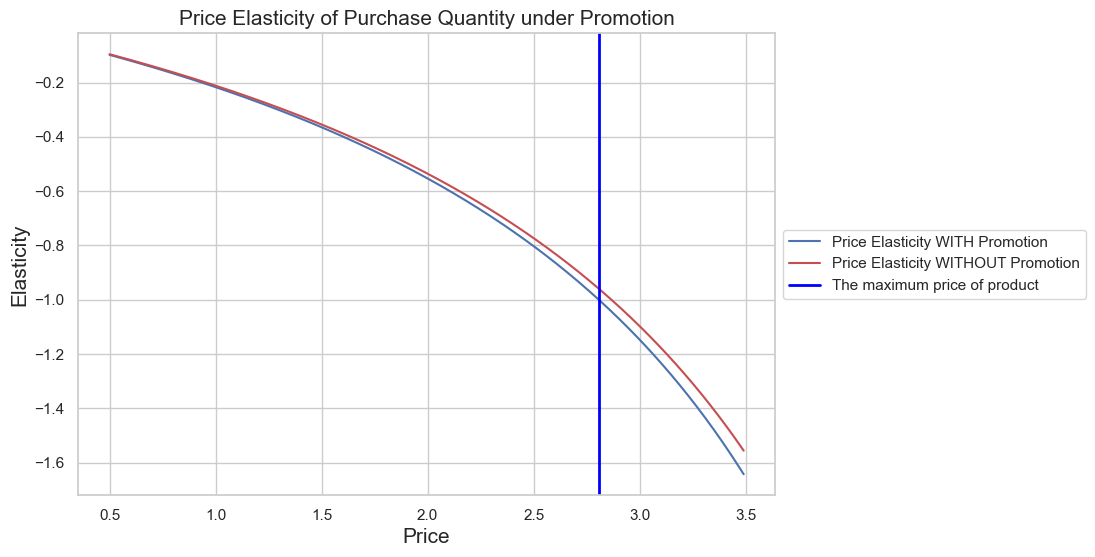

In [14]:
# Plot the two elasticities side by side. 
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_yes, color = 'b', label = 'Price Elasticity WITH Promotion') 
plt.plot(price_range, price_elasticity_quantity_promotion_no, color = 'r', label = 'Price Elasticity WITHOUT Promotion') 
plt.xlabel('Price',  fontsize =15)
plt.ylabel('Elasticity',  fontsize =15)
plt.title('Price Elasticity of Purchase Quantity under Promotion',  fontsize =15)
plt.axvline(2.81, color='blue', linewidth=2, label = 'The maximum price of product')
# show the legend
plt.legend( bbox_to_anchor = (1, 0.5), loc = 6)
plt.show()

- The plot shows that that customers are a little bit **more elastic** when there is a promotion. However overall customers are inelastic towards purchase quantity for all prices from 0,5 dollars to ca. 2.80 dollars. The most expensive brand cost 2,80 dollars. below 2,80 dollars. The two lines practically overlap at many of the price points.  Thus, neither price nor promotions shifts appear to affect the customer's decision. based on this analysis.


#### Conclusion
> Throughout this analysis, I analysed customers in FMCG industry. 
>- Part1: Applying several basic techniques such as K-Means clustering and dimensionality reduction with PCA, I conducted segmentation marketing efforts in the first part of analysis.
>- Part2: Then in the purchase analytics. I combined the segmentation results with some descriptive statistics. This analysis allowed me to extract some unexpected insights about the revenue distribution by brand and by customer segment. Finally, by modelling with linear and logistic regression, I quantified the elasticities of purchase probability brand choice and purchase quantity. The findings provide a fresh perspective on the different pricing strategies we could pursue in order to sustain or maximize the revenue.
